In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import (cross_val_score,
                                     train_test_split,
                                     GridSearchCV,
                                     KFold,
                                     StratifiedKFold,
                                     learning_curve,
                                     validation_curve)
from sklearn.pipeline import make_pipeline

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context('notebook')

In [2]:
data = datasets.load_breast_cancer()
X = data['data']
y = data['target']
df = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1), columns=list(
    data['feature_names']) + ['label'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, test_size=0.3, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((398, 30), (398,), (171, 30), (171,))

In [4]:
log_model = make_pipeline(StandardScaler(), LogisticRegression())
print(
    f'3-fold CV accuracy : {cross_val_score(log_model, X_train, y_train, cv=3).mean():.2%}')

3-fold CV accuracy : 98.49%


In [5]:
log_model.fit(X_train, y_train)
print(f'Test accuracy : {accuracy_score(y_test, log_model.predict(X_test)):.2%}')

Test accuracy : 96.49%


# DummyModel - Baseline model
- DummyClassifier: strategies can be: stratified, uniform, most_frequent, constant
- DummyRegressor: strategies can be: mean, constant median, quantile

In [6]:
# Create dummy classifier
baseline_clf = DummyClassifier(strategy='stratified')
baseline_clf.fit(X_train, y_train)
accuracy_score(y_test, baseline_clf.predict(X_test))

0.5321637426900585

# Cross Validation
We can either use cv=int or specify strategy to generate the folds such as KFold object or generator

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [8]:
cross_val_score(log_model, X_train, y_train, n_jobs=-1, scoring='accuracy', cv=kf).mean()

0.977373417721519

In [9]:
cross_val_score(log_model, X_train, y_train, n_jobs=-1, scoring='accuracy', cv=5).mean()

0.9824367088607595

# Make scorer
We can use custom scoring function and then wrap it up using `make_scorer()` from sklearn.metrics to provide for GridSearchCV() or cross_val_score

In [10]:
make_scorer()

TypeError: make_scorer() missing 1 required positional argument: 'score_func'

# Classification report

In [11]:
print(classification_report(y_test, log_model.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.97      0.94      0.95        64
        yes       0.96      0.98      0.97       107

avg / total       0.96      0.96      0.96       171



# Nested CV
It's better to use to get an unbiased CV metric by having an inner CV such as GridSearchCV to select the best hyperparameters and then use outer CV such as cross_val_score to get the model's performance using the best hyperparameters we got from GridSearchCV

# Learning Curves

In [12]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(),
                                                        X_train, y_train,
                                                        scoring='accuracy',
                                                        cv=kf,
                                                        n_jobs=-1)

train_mean = 1 - train_scores.mean(axis=1)
test_mean = 1 - test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

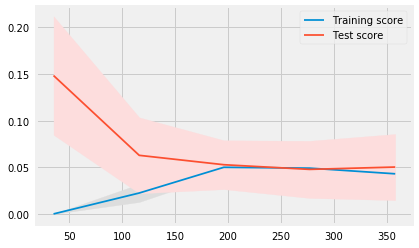

In [13]:
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Test score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#FDDDDD')
plt.legend()

# ROC

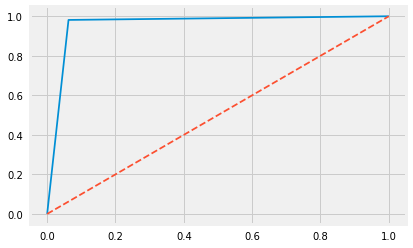

In [14]:
fpr, tpr, _ = roc_curve(y_test, log_model.predict(X_test))
plt.plot(fpr, tpr)
plt.plot([0,1], ls='--');

In [15]:
print(f'AUC : {roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1]):.2%}')

AUC : 99.45%


# Validation Curve

In [16]:
train_scores, test_scores = validation_curve(LogisticRegression(),
                                            X_train, y_train,
                                            param_name='C',
                                            param_range=np.logspace(-4, 4, 10),
                                            scoring='accuracy',
                                            cv=kf,
                                            n_jobs=-1)

train_mean = 1 - train_scores.mean(axis=1)
test_mean = 1 - test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

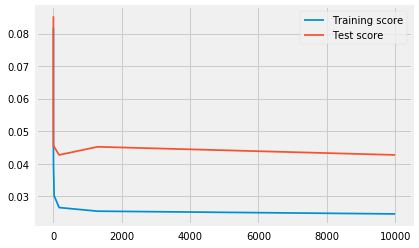

In [17]:
plt.plot(np.logspace(-4, 4, 10), train_mean, label='Training score')
plt.plot(np.logspace(-4, 4, 10), test_mean, label='Test score')
# plt.fill_between(np.logspace(-4, 4, 100), train_mean - train_std, train_mean + train_std)
# plt.fill_between(np.logspace(-4, 4, 100), test_mean - test_std, test_mean + test_std)
plt.legend();

In [18]:
np.logspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])